Inorder to train baseline models on custom w2v dataset please use baseline model python file from github repo* here :
https://github.com/HealthMLInterpretability/predicting_ICD9/tree/main/Code%20-%20Python%20Version%20Arya

## 1. Importing Libraries

In [ ]:
!pip install contractions
import nltk
nltk.download('wordnet')
import pandas as pd
from tqdm import tqdm
import numpy as np
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
import contractions
from sklearn.metrics import accuracy_score
import keras
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.layers import Embedding
from keras.layers import Input, Flatten
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopwords_collections=set(stopwords.words('english'))
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AI Projects and Dataset/Health ML/cleaned_dataset_with_digits.csv")  # Loading dataset

In [ ]:
df= df.rename(columns={"TEXT":"text"}) 

In [ ]:
df = df.iloc[:, 0:2]

In [ ]:
df.head()

,text,label
0,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This 60 ...,3
1,CHIEF COMPLAINT: Substernal Chest Pain\n\nPRES...,2
2,CHIEF COMPLAINT: chest pain\n\nPRESENT ILLNESS...,0
3,CHIEF COMPLAINT: Presented with respiratory di...,2
4,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,2


In [ ]:
df.sample(frac = 1)

,text,label
4165,CHIEF COMPLAINT: Shortness of breath and fatig...,2
7934,CHIEF COMPLAINT: Angina.\n\nPRESENT ILLNESS: T...,2
4303,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: This pat...,1
10349,CHIEF COMPLAINT: chest pain\n\nPRESENT ILLNESS...,2
1903,CHIEF COMPLAINT: abdominal compartment syndrom...,1
...,...,...
7633,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: Mr. [**K...,1
1947,CHIEF COMPLAINT: weakness\n\nPRESENT ILLNESS: ...,2
4267,CHIEF COMPLAINT: This is a transfer from [**Ho...,2
9980,CHIEF COMPLAINT: chest pain\n\nPRESENT ILLNESS...,2


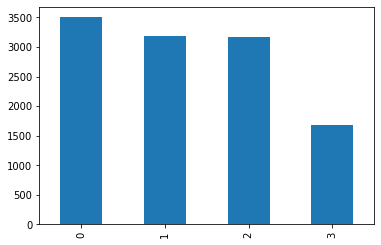

In [ ]:
df.label.value_counts().plot(kind = "bar")

## 2. Data Cleaning

In [ ]:
import re
stemmer = WordNetLemmatizer()

In [ ]:
def clean_Text(text:str):
    # Remove new line characters
    text = text.replace("\n", ' ')
    # Punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    # Remove numerical values ??? really ????
    text = ''.join(i for i in text if not i.isdigit())
    #Removing Stopwords
    text = ' '.join([i for i in text.split() if not i in stopwords_collections])
    #Removing certain sized words
    text = ' '.join([i for i in text.split() if len(i)>=2]) #>=2 to take care of units like cm, pb etc
    # Contractions
    text = contractions.fix(text)
    # Converting to Lowercase
    text = text.lower()
    # Lemmatization
    text = text.split()
    text = [stemmer.lemmatize(word) for word in text]
    text = ' '.join(text)
    #Removing my_stop_words
    text = ' '.join([i for i in text.split() if not i in stopwords_collections and i != "year" and i!= "old"])
    #return document
    return text
   

In [ ]:
import tqdm

In [ ]:
df.text = df.text.apply(lambda x: clean_Text(x))

In [ ]:
df.text[0]

'chief complaint present illness white male known murmur since childhood status post inferior myocardial infarction anteroseptal myocardial infarction status post angioplasty time since increased dyspnea exertion echocardiogram revealed aortic stenosis mm gradient ejection fraction apical akinesis cardiac catheterization revealed ejection fraction mitral regurgitation moderate mac left anterior descending mid lesion diagonal lesion right coronary artery mid occlusion admitted aortic valve replacement coronary artery bypass graft medical history significant history skin cancer left shoulder history hypothyroidism history hypercholesterolemia history hypertension history coronary artery disease status post angioplasty status post inferior myocardial infarction anteroseptal myocardial infarction medication admission allergy known drug allergy physical exam family history significant coronary artery disease social history'

In [ ]:
df.head(2)

,text,label
0,chief complaint present illness white male kno...,3
1,chief complaint substernal chest pain present ...,2


In [ ]:
# df.to_csv("cleaned_dataset_non_numerical_for_w2v.csv", index = False)

## 3. Creating Custom Word Embeddings

In [ ]:
clinical_Text = list(df.text.apply(str.split).values)

In [ ]:
len(clinical_Text)

11537

In [ ]:
from gensim import models
import time
# from gensim.models.phrases import Phrases, Phraser
import multiprocessing
# phrases = Phrases(clinical_Text, min_count=30, progress_per=10000)

In [ ]:
# bigram = Phraser(phrases)

In [ ]:
# clinical_Text = bigram[clinical_Text]

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

Selecting Epochs to train Gensim Word2Vec: https://datascience.stackexchange.com/questions/9819/number-of-epochs-in-gensim-word2vec-implementation

Which one to choose Skip gram or CBOW: https://stackoverflow.com/questions/39224236/word2vec-cbow-skip-gram-performance-wrt-training-dataset-size#:~:text=Overall%2C%20the%20best%20practice%20is%20to%20try%20few%20experiments%20and%20see%20what%20works%20the%20best%20for%20you%2C%20as%20different%20applications%20have%20different%20requirements.

In [ ]:
start_time = time.time()
model = models.Word2Vec(sentences=clinical_Text,
                 window = 150, #The maximum distance between a target word and words around the target word. 
                 sg=1, # The training algorithm, either CBOW (0) or skip gram (1). ## initially used sg=1 # https://stackoverflow.com/questions/39224236/word2vec-cbow-skip-gram-performance-wrt-training-dataset-size
                 size=100,  #The number of dimensions of the embedding, 300, 100, 50
                 workers=8,#The number of threads to use while training.
                 sample=6e-5,
                 min_count=1) 

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 5.48 mins


In [ ]:
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 26169


Vocabulary size: 26169

In [ ]:
len(model.wv.vocab.keys())

26169

In [ ]:
model.wv.vector_size

100

In [ ]:
model.wv.get_vector('disease')

array([-0.274735  ,  0.08529156,  0.06623887, -0.09882965,  0.2249899 ,
       -0.22288945, -0.12112001, -0.20703386,  0.2533214 ,  0.00489836,
        0.4074912 ,  0.27807114, -0.3370825 ,  0.03539487,  0.00291168,
        0.1745567 , -0.1620663 ,  0.02849971,  0.24876998, -0.19635521,
        0.23642896,  0.02705242,  0.23832667, -0.27842474, -0.0205157 ,
        0.03685153, -0.03243324,  0.13095213, -0.01527753,  0.28073865,
        0.3458754 , -0.08356009, -0.13318944,  0.18755627,  0.19802876,
       -0.04977775, -0.0746841 , -0.17505257, -0.06272782,  0.04075254,
       -0.00170807, -0.31347305, -0.15657668, -0.16293992, -0.08885756,
        0.5200669 , -0.22648984,  0.2113484 ,  0.13450508, -0.07247527,
       -0.07570169, -0.07483209,  0.1845369 ,  0.16101305, -0.03870905,
       -0.27291083,  0.05675648, -0.33985275,  0.2519686 , -0.04921775,
        0.18389945,  0.02028033, -0.04330709, -0.19888282, -0.04616175,
        0.12756912,  0.06722473,  0.02413679, -0.11020845,  0.09

In [ ]:
len(model.wv.get_vector('sepsis'))

100

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
model.similar_by_word('disease')

[('coronary', 0.8803753852844238),
 ('hypertension', 0.8752390146255493),
 ('history', 0.8693022727966309),
 ('vessel', 0.8682012557983398),
 ('artery', 0.8575736284255981),
 ('left', 0.8383479118347168),
 ('three', 0.8358386754989624),
 ('medical', 0.8309374451637268),
 ('revealed', 0.8222615122795105),
 ('hypercholesterolemia', 0.8196888566017151)]

In [ ]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize =(10,8))
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

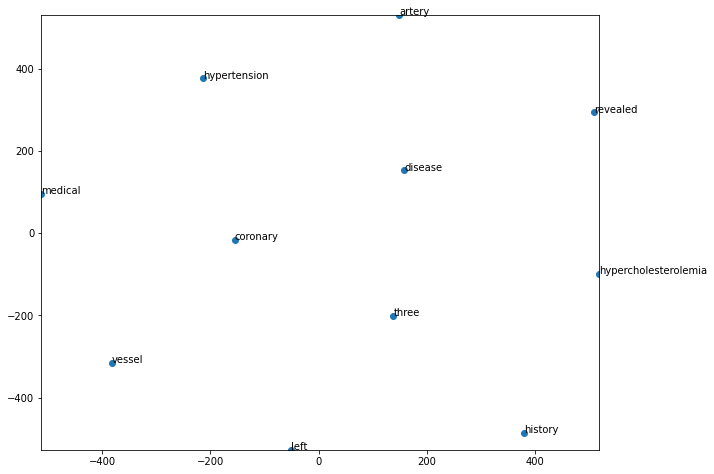

In [ ]:
display_closestwords_tsnescatterplot(model, 'disease')

In [ ]:
from gensim.models import Word2Vec, KeyedVectors   
model.wv.save_word2vec_format('w2v_model_100_non_bi.bin', binary=True)

In [ ]:
model.wv.save_word2vec_format('clinical_glove_100d_non_bi.txt')

In [ ]:
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
from nltk.tokenize.toktok import ToktokTokenizer

In [ ]:
tn = ToktokTokenizer()

In [ ]:
train, test = train_test_split(df, test_size = 0.3)

In [ ]:
train_text = list(train.text)

In [ ]:
train_label = list(train.label)

In [ ]:
test_text = list(test.text)
test_label = list(test.label)

In [ ]:
num_classes=4
# tokenize train reviews & encode train labels
tokenized_train = [tn.tokenize(text)
                   for text in train_text]
y_train = keras.utils.np_utils.to_categorical(train_label, num_classes)
# tokenize test reviews & encode test labels
tokenized_test = [tn.tokenize(text)
                   for text in test_text]
y_test = keras.utils.np_utils.to_categorical(test_label, num_classes)

In [ ]:
vocab = model.wv.vocab  

In [ ]:
all_words = []
for (x,y) in vocab.items():
  all_words.append(x)

In [ ]:
vocab_size = len(all_words) + 1
vocab_size

26170

In [ ]:
df.isna().sum()

text     0
label    0
dtype: int64

In [ ]:
len(tokenized_train), len(tokenized_test), train.shape, test.shape

(8075, 3462, (8075, 2), (3462, 2))

In [ ]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=model,
                                                     num_features=50)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=model,
                                                    num_features=50)

In [ ]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(num_input_features,)))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(4))
    dnn_model.add(Activation('softmax'))
    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [ ]:
w2v_dnn = construct_deepnn_architecture(num_input_features=50)

In [ ]:
batch_size = 8
history = w2v_dnn.fit(avg_wv_train_features, y_train, epochs=15, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/15
909/909 [==============================] - 5s 5ms/step - loss: 0.5129 - accuracy: 0.8108 - val_loss: 0.4491 - val_accuracy: 0.8168
Epoch 2/15
909/909 [==============================] - 4s 5ms/step - loss: 0.4730 - accuracy: 0.8225 - val_loss: 0.4385 - val_accuracy: 0.8366
Epoch 3/15
909/909 [==============================] - 4s 4ms/step - loss: 0.4629 - accuracy: 0.8320 - val_loss: 0.4459 - val_accuracy: 0.8354
Epoch 4/15
909/909 [==============================] - 4s 5ms/step - loss: 0.4556 - accuracy: 0.8283 - val_loss: 0.4401 - val_accuracy: 0.8329
Epoch 5/15
909/909 [==============================] - 4s 4ms/step - loss: 0.4446 - accuracy: 0.8331 - val_loss: 0.4094 - val_accuracy: 0.8354
Epoch 6/15
909/909 [==============================] - 4s 5ms/step - loss: 0.4438 - accuracy: 0.8316 - val_loss: 0.4272 - val_accuracy: 0.8304
Epoch 7/15
909/909 [==============================] - 4s 4ms/step - loss: 0.4363 - accuracy: 0.8384 - val_loss: 0.4078 - val_accuracy: 0.8379
Epoch 

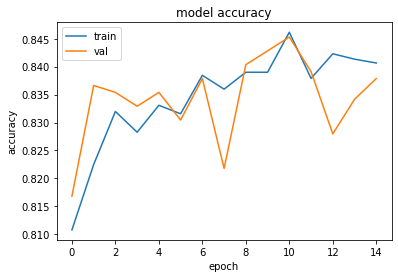

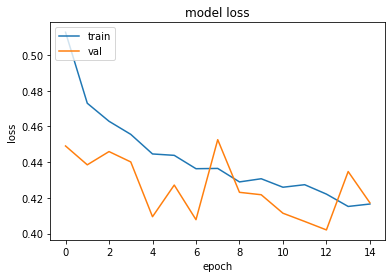

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = w2v_dnn.predict(avg_wv_test_features)

In [ ]:
classes_x=np.argmax(y_pred,axis=1)
len(classes_x), len(avg_wv_test_features)

(3462, 3462)


accuracy: 85.0664 %


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1076
           1       0.93      0.97      0.95       949
           2       0.82      0.78      0.80       961
           3       0.85      0.83      0.84       476

    accuracy                           0.85      3462
   macro avg       0.85      0.85      0.85      3462
weighted avg       0.85      0.85      0.85      3462



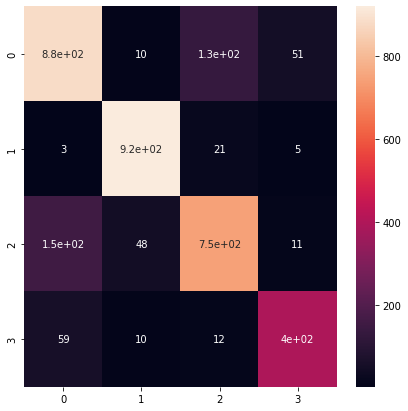

In [ ]:
accuracy = accuracy_score(test_label, classes_x)
print()
print("accuracy:",np.round(accuracy*100,4),"%")
print()
# plotting the confusion matrix
cm = confusion_matrix(test_label, classes_x)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
print()
report = classification_report(test_label, classes_x, labels = [0,1,2,3])
print((report))

accuracy: 82.1779 %

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1076
           1       0.94      0.95      0.95       949
           2       0.83      0.74      0.78       961
           3       0.91      0.67      0.77       476

    accuracy                           0.82      3462
   macro avg       0.85      0.80      0.82      3462
weighted avg       0.83      0.82      0.82      3462



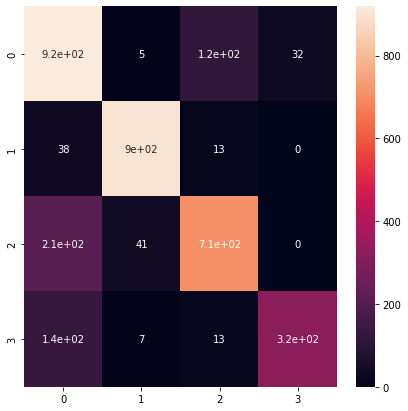

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, max_depth = 10)
forest = forest.fit(avg_wv_train_features, y_train)
result = forest.predict(avg_wv_test_features)
classes_x=np.argmax(result,axis=1)
len(classes_x), len(avg_wv_test_features)
accuracy = accuracy_score(test_label, classes_x)
print("accuracy:",np.round(accuracy*100,4),"%")
# plotting the confusion matrix
cm = confusion_matrix(test_label, classes_x)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
print()
report = classification_report(test_label, classes_x, labels = [0,1,2,3])
print((report))


accuracy: 74.0324 %


              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1076
           1       0.90      0.91      0.90       949
           2       0.68      0.70      0.69       961
           3       0.69      0.66      0.67       476

    accuracy                           0.74      3462
   macro avg       0.74      0.73      0.73      3462
weighted avg       0.74      0.74      0.74      3462



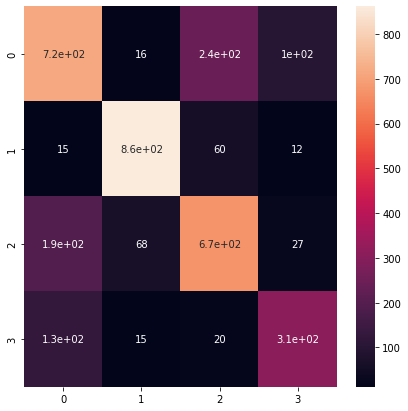

In [ ]:
from sklearn.tree import DecisionTreeClassifier
modelDTC = DecisionTreeClassifier()
modelLR = modelDTC.fit(avg_wv_train_features, y_train)
result = modelLR.predict(avg_wv_test_features)
classes_x=np.argmax(result,axis=1)
accuracy = accuracy_score(test_label, classes_x)
print()
print("accuracy:",np.round(accuracy*100,4),"%")
print()
# plotting the confusion matrix
cm = confusion_matrix(test_label, classes_x)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
print()
report = classification_report(test_label, classes_x, labels = [0,1,2,3])
print((report))

In [ ]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)


accuracy: 79.3472 %


              precision    recall  f1-score   support

           0       0.65      0.86      0.74      1076
           1       0.95      0.92      0.93       949
           2       0.81      0.66      0.72       961
           3       0.92      0.68      0.78       476

    accuracy                           0.79      3462
   macro avg       0.83      0.78      0.79      3462
weighted avg       0.81      0.79      0.79      3462



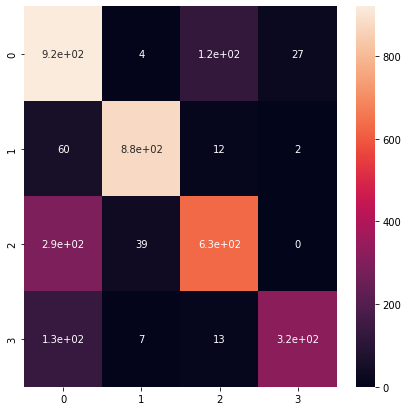

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
modelKNN = KNeighborsClassifier(n_neighbors=4)
modelKNN = modelKNN.fit(avg_wv_train_features, y_train)
result = modelKNN.predict(avg_wv_test_features)
classes_x=np.argmax(result,axis=1)
accuracy = accuracy_score(test_label, classes_x)
print()
print("accuracy:",np.round(accuracy*100,4),"%")
print()
# plotting the confusion matrix
cm = confusion_matrix(test_label, classes_x)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
print()
report = classification_report(test_label, classes_x, labels = [0,1,2,3])
print((report))

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X = df.text
Y = df.label
X_avg = averaged_word2vec_vectorizer(X, model, 50)

In [ ]:
kmeans = KMeans(n_clusters = 4).fit(X_avg)
# kmeans_pred = kmeans.predict(avg_wv_test_features)
pred = kmeans.labels_
correct_labels = sum(Y == pred)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, len(Y)))
print('Accuracy score:', np.round((correct_labels/float(len(Y)))*100, 2)," %")

Result: 1786 out of 11537 samples were correctly labeled.
Accuracy score: 15.48  %


In [ ]:
def build_numerical_dataset(features, df_kms:pd.DataFrame, isCategorical= False, num_classes = 4):
  columns = np.arange(0,features)
  df = df_kms.copy()
  for x in range(0,df.shape[0]):
    df.vectors[x] = df.vectors[x].tolist()[0]
  print("Input dataframe shape:", df.shape)
  df_split = pd.DataFrame(df["vectors"].to_list(), columns=columns)
  df_split.iloc[:1, :]
  df_split['label'] = df_kms.label
  print("Output dataframe shape:", df_split.shape)
  if isCategorical == True:
    df_split['label'] = keras.utils.np_utils.to_categorical(df_split['label'], num_classes)
    return df_split
  return df_split

In [ ]:
def text2vec(text, model):
    return np.mean([model[x] for x in text.split() if x in model.wv.vocab], axis=0, dtype=np.float64).reshape(1,-1)

In [ ]:
def build_experimental_dataset(df: pd.DataFrame, model, column_Name:str, features:int):
  text = column_Name
  df_experimental = df.copy()
  df_experimental['vectors'] = df_experimental.text.apply(text2vec, model = model)
  df = build_numerical_dataset(features, df_experimental, isCategorical= False, num_classes = 4)
  return df

In [ ]:
df_kms =  build_experimental_dataset(df, model, "text", 50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Input dataframe shape: (11537, 3)
Output dataframe shape: (11537, 51)


In [ ]:
df_kms.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,label
0,0.956331,-1.242517,0.164691,0.229886,0.586345,1.055610,0.126580,-1.076944,1.255002,-0.550286,...,-0.165255,-2.527203,0.712223,-0.063162,1.080028,-1.188796,0.307747,-0.274595,-0.113595,3
1,-0.640006,0.925016,-0.020975,-0.558875,0.740552,-0.239525,-0.770637,-0.432827,0.526704,0.087798,...,-0.323298,-0.781846,-0.849738,1.124323,0.064199,-0.361936,-0.188822,0.489599,0.504159,2
2,-0.336944,1.168275,-0.032232,-1.194962,0.803278,0.886005,0.950325,0.002747,0.351473,-0.760623,...,-0.757919,-1.016364,-1.266740,1.650059,0.059014,-0.632728,-0.858026,0.270566,1.136930,0
3,0.023629,0.464237,-0.474074,-0.426486,0.021481,-0.284042,0.181543,-0.267346,0.238543,-0.166309,...,-0.113214,-0.681744,0.246721,0.617094,0.774392,-0.143180,0.018832,-0.100191,0.017536,2
4,0.414522,-0.364232,0.419396,-0.219412,1.572868,0.593370,-0.917239,-1.304608,0.530757,-0.498689,...,-0.222291,-2.206959,-0.638767,0.863116,0.251835,-1.226593,-0.090007,0.335422,-0.189652,2


In [ ]:
df_kms_copy = df_kms.copy()

In [ ]:
Y = df_kms_copy.label

In [ ]:
df_kms_copy.drop(columns={'label'}, inplace = True)

In [ ]:
X = df_kms_copy
print(Y.shape, X.shape)

(11537,) (11537, 50)


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

In [ ]:
pred = kmeans.labels_

In [ ]:
Y = df_kms.label

In [ ]:
correct_labels = sum(Y == pred)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, len(Y)))
print('Accuracy score:', np.round((correct_labels/float(len(Y)))*100, 2)," %")

Result: 6390 out of 11537 samples were correctly labeled.
Accuracy score: 55.39  %


In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
tqdm.pandas()
import keras
from keras.utils import np_utils
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
def classification_metrics(test_labels, predicted_labels, model_name):
  print(f"--------------{model_name}----------------------")
  accuracy = accuracy_score(test_labels, predicted_labels)
  bal_acc = balanced_accuracy_score(test_labels, predicted_labels)
  recall =  recall_score(test_labels, predicted_labels, average='micro')
  f1_weighted = f1_score(test_labels, predicted_labels, average='weighted')
  f1_average = f1_score(test_labels, predicted_labels, average='micro')
  precision = precision_score(test_labels, predicted_labels, average='micro')
  print("accuracy:",np.round(accuracy*100,4),"%")
  print("balanced_ accuracy:",np.round(bal_acc*100,4),"%")
  print("recall:",np.round(recall*100,4),"%")
  print("f1_weighted:",np.round(f1_weighted*100,4),"%")
  print("f1_average:",np.round(f1_average*100,4),"%")
  print("precision:",np.round(precision*100,4),"%")
  print()
  cm = confusion_matrix(test_labels, predicted_labels)
  plt.figure(figsize = (7,7))
  sns.heatmap(cm, annot=True)
  print()
  report = classification_report(test_labels, predicted_labels, labels = [0,1,2,3])
  print((report))
  print("----------------------------------------------------")

--------------K Means----------------------
accuracy: 55.387 %
balanced_ accuracy: 51.5327 %
recall: 55.387 %
f1_weighted: 57.7336 %
f1_average: 55.387 %
precision: 55.387 %


              precision    recall  f1-score   support

           0       0.52      0.45      0.49      3502
           1       0.91      0.91      0.91      3184
           2       0.68      0.49      0.57      3175
           3       0.11      0.21      0.15      1676

    accuracy                           0.55     11537
   macro avg       0.56      0.52      0.53     11537
weighted avg       0.62      0.55      0.58     11537

----------------------------------------------------


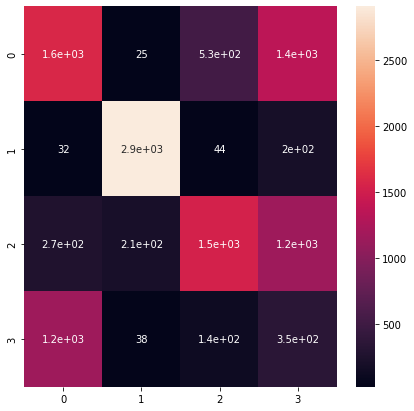

In [ ]:
classification_metrics(Y, pred, "K Means")